In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# need z for each asset and time step and condition number for each timestep
# existing script takes all_stocks.csv so here we will transform data into form below

In [6]:
# all_stocks.csv form
df = pd.read_csv('/Users/zachariemartin/Desktop/School/Projects/summer2019/sum19/data/all_stocks_5yr.csv')
col_list = df.columns.values
col_list[2:4] = 'Condition Number'

df.head()

,Date,Open,Condition Number,Condition Number,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [7]:
# note shape: (num_assets*length,columns). data for each asset eg. MMM occupies contiguous rows 0:3000
print(df.shape)

(606801, 7)


In [8]:
# note: this is what the change between assets looks like 1257:1258
df.loc[1250:1260,:]

,Date,Open,Condition Number,Condition Number,Close,Volume,Name
1250,2017-08-02,203.19,205.60,202.82,205.41,2029646.0,MMM
1251,2017-08-03,205.91,207.64,205.12,207.62,2054236.0,MMM
1252,2017-08-04,207.95,208.61,206.11,207.65,1522668.0,MMM
1253,2017-08-07,207.90,208.40,206.68,207.44,1172563.0,MMM
1254,2017-08-08,206.83,207.89,205.69,206.43,1856282.0,MMM
1255,2017-08-09,206.69,207.91,205.59,206.48,1622213.0,MMM
1256,2017-08-10,205.62,207.16,205.18,206.23,1571545.0,MMM
1257,2017-08-11,206.85,206.85,205.63,205.98,1452811.0,MMM
1258,2012-08-13,32.93,33.02,32.84,33.00,5290056.0,ABT
1259,2012-08-14,33.08,33.14,32.95,33.08,5499012.0,ABT


In [9]:
filename = 'all_stocks_5yr_1.csv'
df.to_csv(filename,index=False)

In [25]:
# load simulated z data and condition number df
dfz = pd.read_csv('/Users/zachariemartin/Desktop/School/Projects/summer2019/sum19/data/mgarch_sim_3000_z100_1.csv')
dfc = pd.read_csv('data/mgarch_sim_3000_condnum.csv').rename(columns={'Unnamed: 0':'Date'}).set_index('Date')
dfz = dfz.set_index(dfc.index).drop('Unnamed: 0',axis=1)

In [26]:
# how we scale condition number
max_c = dfc.loc[:,'condition number'].max()
min_c = dfc.loc[:,'condition number'].min()
example_cond_at_t = 348
(example_cond_at_t - min_c) / (max_c - min_c)

0.004917314390298771

$f(\sigma_t) = \frac{\sigma_t - \min\{\sigma\}_{1:T}}{\min\{\sigma\}_{1:T} - \min\{\sigma\}_{1:T}}$

In [41]:
# need to scale condition number to 0 - 1 range 
# then set trading cost to 1

# from portfolio.py
# mu1 = self.cost * c1 * (np.abs(dw1 - w1)).sum()  # (eq16) cost to change portfolio with condition number cost
# assert mu1 < 1.0, 'Cost is larger than current holding'
# p1 = p0 * (1 - mu1) * np.dot(y1, w1)  # (eq11) final portfolio value

dfc.loc[:,'condition number'] = np.interp(dfc.loc[:,'condition number'],
                                      (dfc.loc[:,'condition number'].min(),dfc.loc[:,'condition number'].max()),(0, +1))


In [42]:
# define
len_sim = dfz.shape[0]
num_assets = 100
print(len_sim)

3000


In [43]:
# create dict of columns matching all_stocks.csv format

d = {}
for i in range(7):
    d[i] = col_list[i]

dfz_ = pd.DataFrame(np.zeros((dfz.shape[0]*dfz.shape[1],len(col_list))))
dfz_ = dfz_.rename(columns = d)

for i in range(dfz.shape[1]):
#     print('{}:{}'.format(i*dfz.shape[0],(i+1)*dfz.shape[0]))
    dfz_.iloc[i*len_sim:(i+1)*len_sim,0] = dfz.index.values
    dfz_.iloc[i*len_sim:(i+1)*len_sim,1] = dfz.iloc[:,i].to_numpy()
    dfz_.iloc[i*len_sim:(i+1)*len_sim,6] = dfz.columns[i]

dfz_['Close'] = dfz_['Open']
dfz_['Volume'] = dfz_['Open']

In [44]:
# set condition number as High,Low columns - these aren't used in original algorithm
dfz_.iloc[:,2] = pd.concat([dfc['condition number']]*num_assets,axis=0).values
dfz_.iloc[:,3] = pd.concat([dfc['condition number']]*num_assets,axis=0).values

In [45]:
# now our dataframe looks like this
dfz_.loc[2995:3000,:]

,Date,Open,Condition Number,Condition Number,Close,Volume,Name
2995,2027-12-17,0.068205,0.001703,0.001703,0.068205,0.068205,AAPL
2996,2027-12-18,0.062254,0.001709,0.001709,0.062254,0.062254,AAPL
2997,2027-12-19,0.069394,0.002047,0.002047,0.069394,0.069394,AAPL
2998,2027-12-20,0.068946,0.006861,0.006861,0.068946,0.068946,AAPL
2999,2027-12-21,0.073587,0.001957,0.001957,0.073587,0.073587,AAPL
3000,2019-10-05,0.006062,0.004928,0.004928,0.006062,0.006062,ACN


In [49]:
# here's how price vector y1 is computed:

### relative price vector of last observation day (close/open)
### close_price_vector = observation[:, -1, 3]
### open_price_vector = observation[:, -1, 0]
### y1 = close_price_vector / open_price_vector

# so we need prices then offset prices open/close

for i in range(dfz.shape[1]):
    dfz_asset = dfz_.iloc[i*len_sim:(i+1)*len_sim,:]
    dfz_asset['Close'] = dfz_asset['Close']
    dfz_asset['Open'] = dfz_asset['Close'].shift(1)
    dfz_asset.loc[i*len_sim,'Open'] = dfz_asset.loc[i*len_sim+1,'Open']

/Users/zachariemartin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/zachariemartin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
# test 
test_df = dfz_.loc[0:2999,:]
test_df['Return'] = (test_df['Close'] - test_df['Open'])

/Users/zachariemartin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
test_df['Return'] = test_df['Return'] + np.ones(len(test_df['Return']))

/Users/zachariemartin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
test_df['Return'].cumprod()

0       1.000000
1       0.992143
2       0.993150
3       0.992527
4       1.002858
5       1.011928
6       1.009382
7       1.016857
8       1.013549
9       1.018501
10      1.013638
11      1.026991
12      1.014872
13      1.011435
14      1.010987
15      1.002681
16      1.003826
17      0.997834
18      0.983767
19      0.981703
20      0.988498
21      0.986532
22      0.975903
23      0.980623
24      0.970012
25      0.974041
26      0.968818
27      0.975063
28      0.980646
29      0.985974
          ...   
2970    0.941503
2971    0.953243
2972    0.951598
2973    0.953871
2974    0.964701
2975    0.968131
2976    0.960898
2977    0.962821
2978    0.959280
2979    0.948891
2980    0.957068
2981    0.954015
2982    0.970435
2983    0.973421
2984    0.961422
2985    0.948998
2986    0.954710
2987    0.946584
2988    0.947085
2989    0.936551
2990    0.952461
2991    0.956163
2992    0.945027
2993    0.950781
2994    0.944975
2995    0.934335
2996    0.928774
2997    0.9354

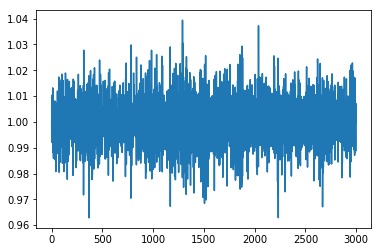

In [84]:
plt.plot(x_len,test_df['Return'])

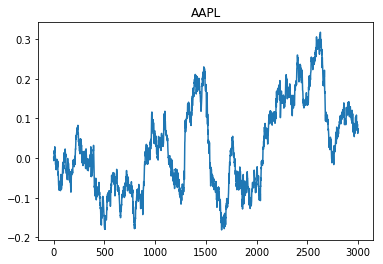

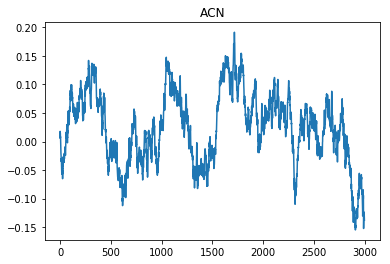

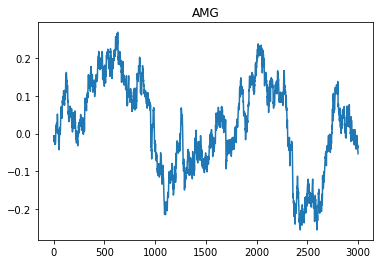

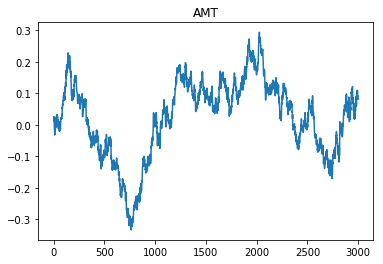

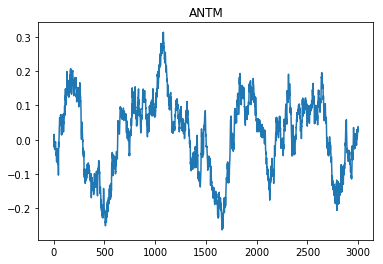

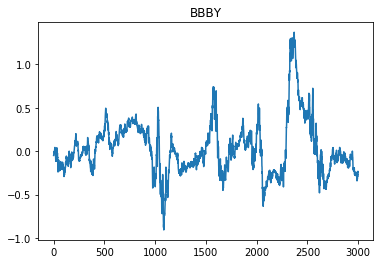

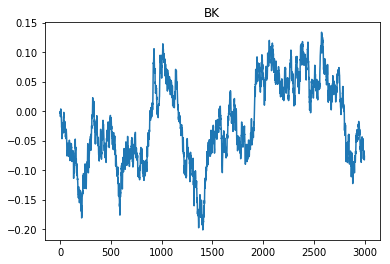

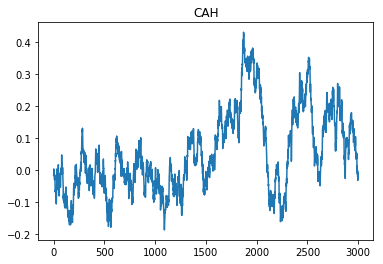

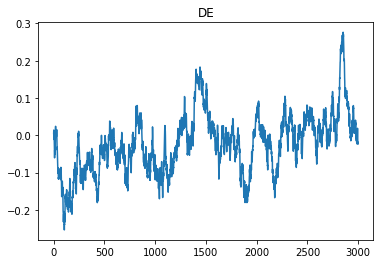

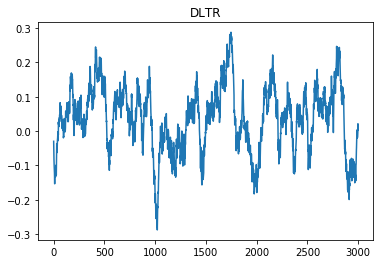

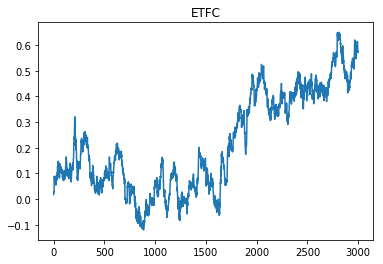

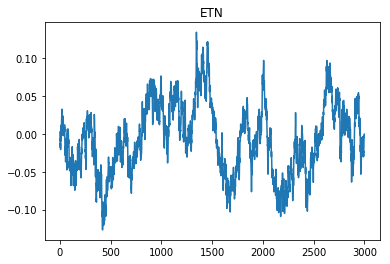

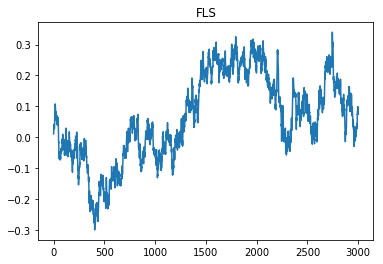

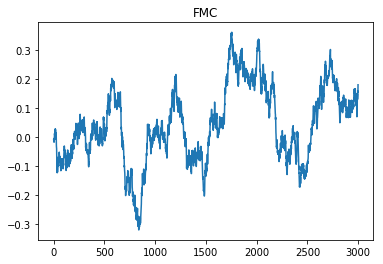

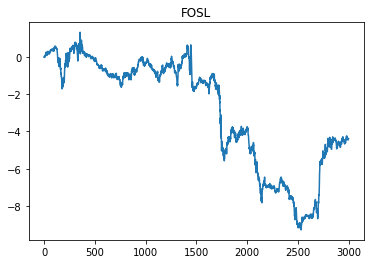

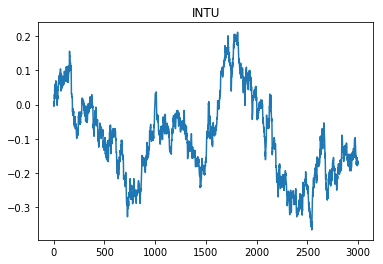

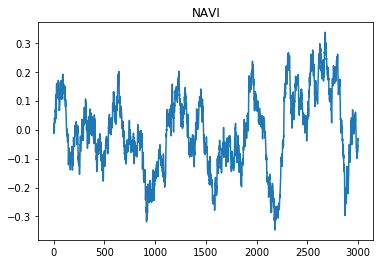

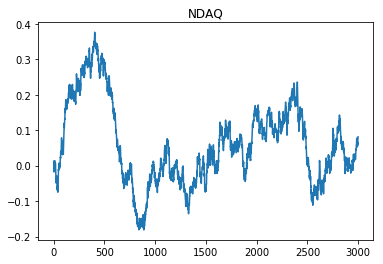

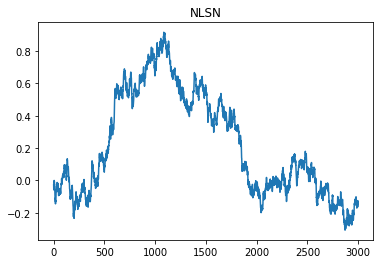

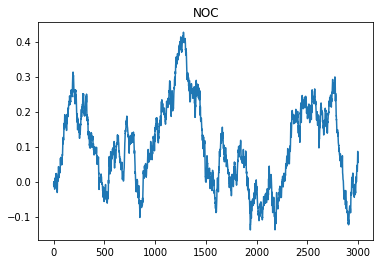

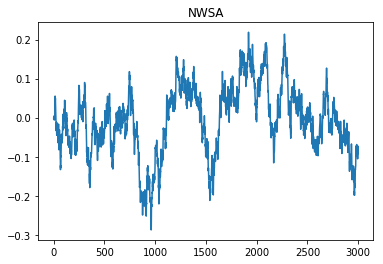

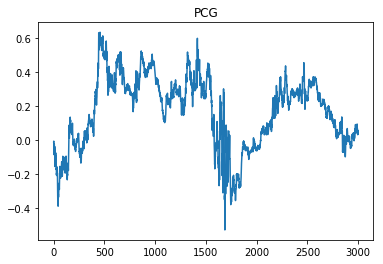

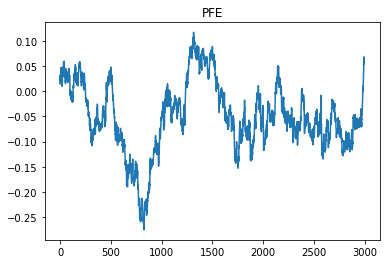

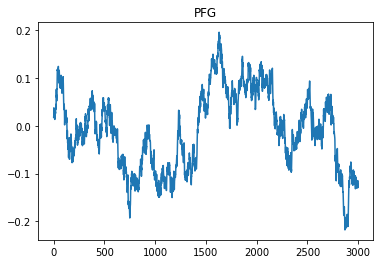

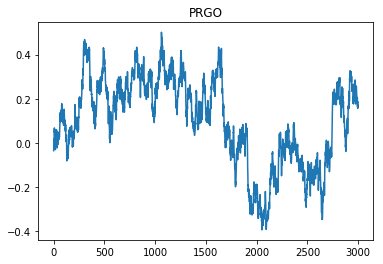

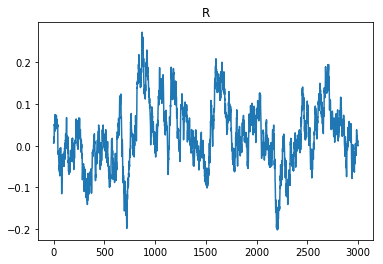

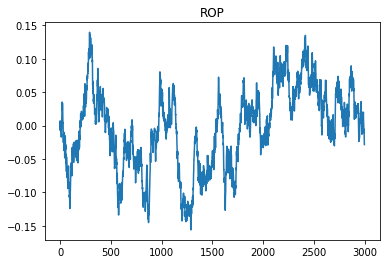

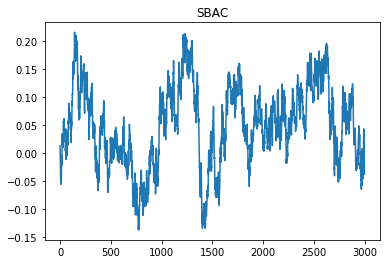

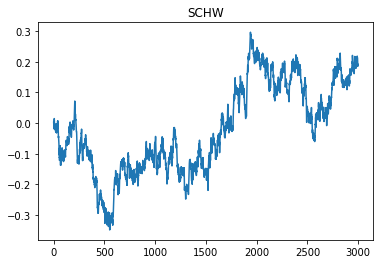

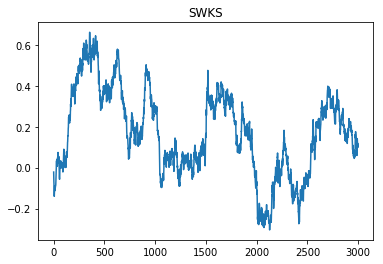

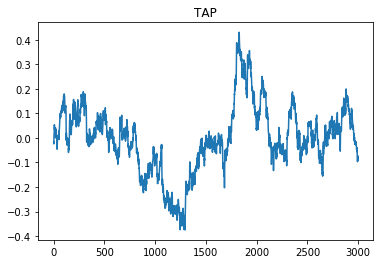

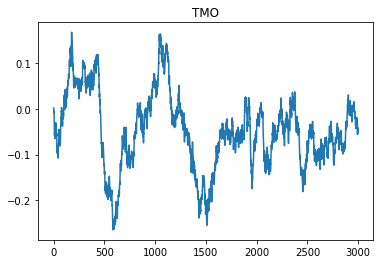

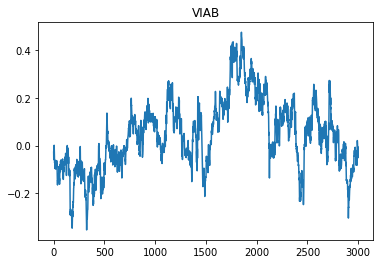

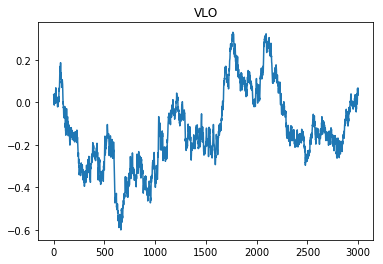

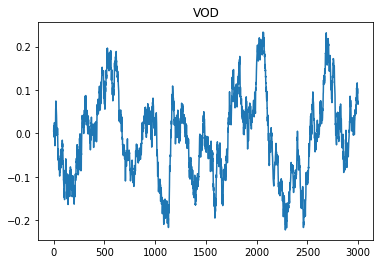

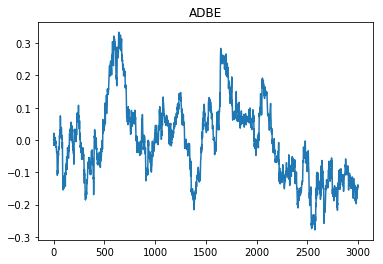

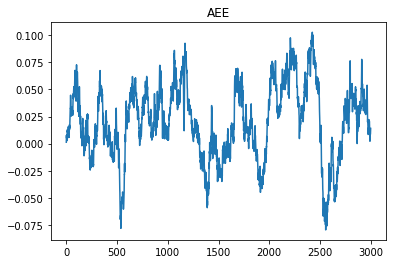

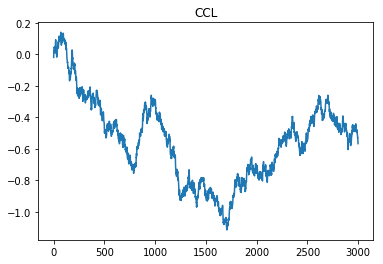

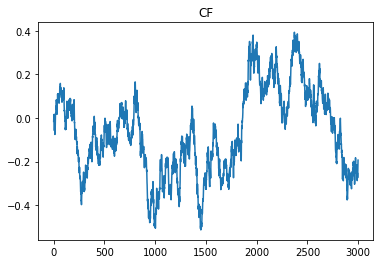

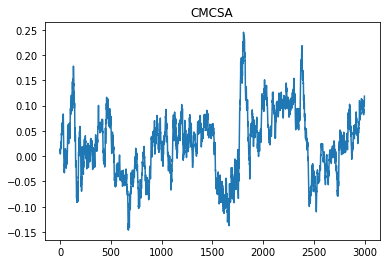

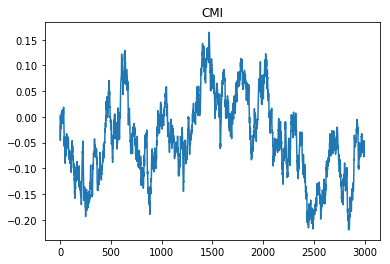

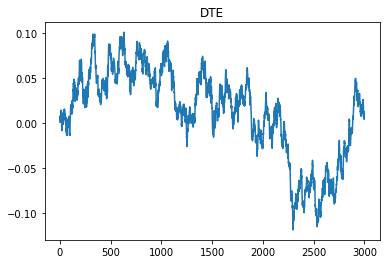

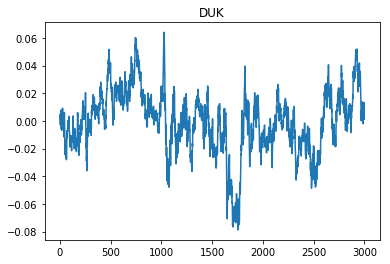

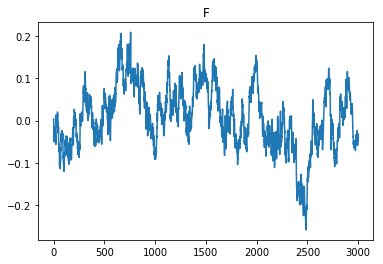

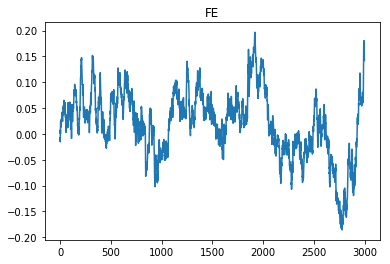

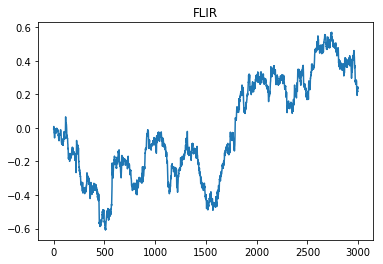

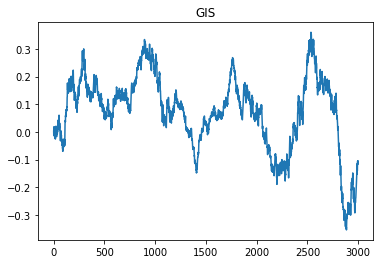

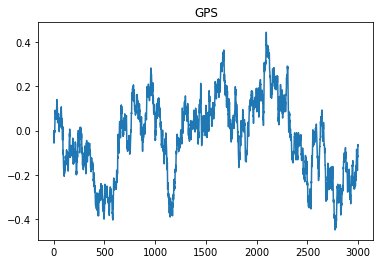

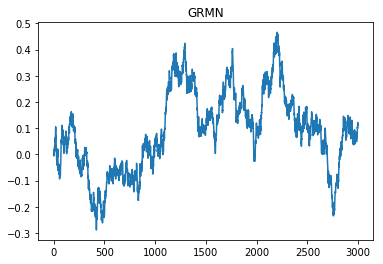

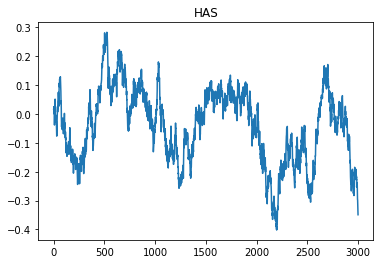

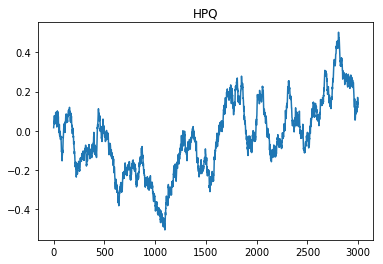

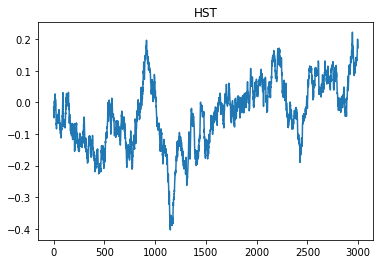

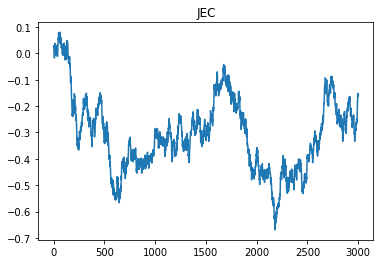

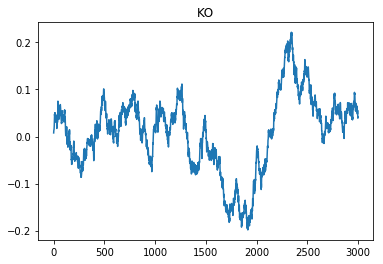

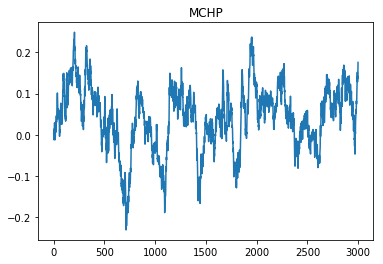

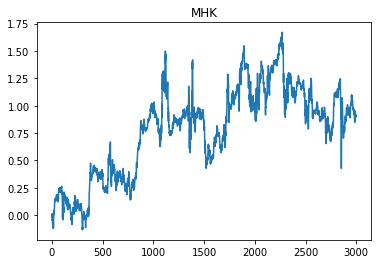

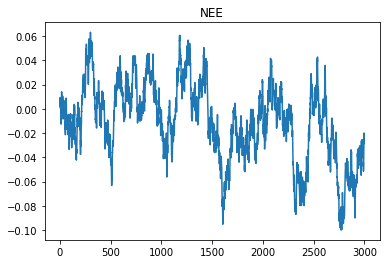

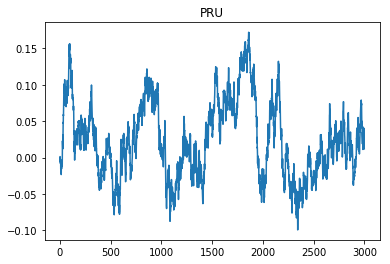

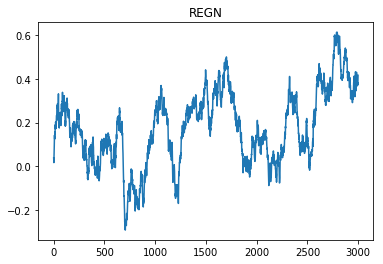

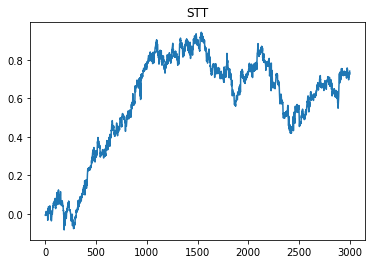

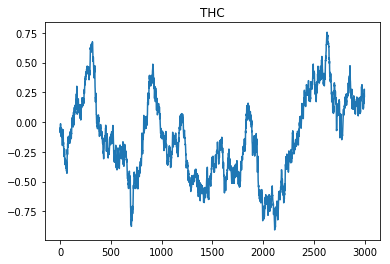

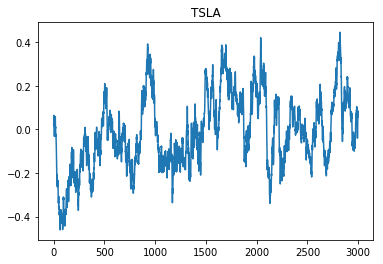

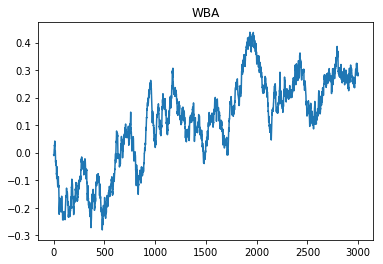

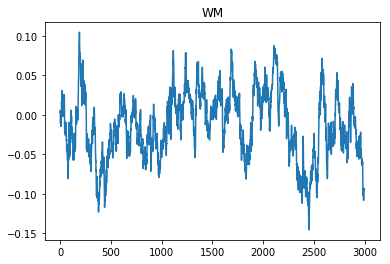

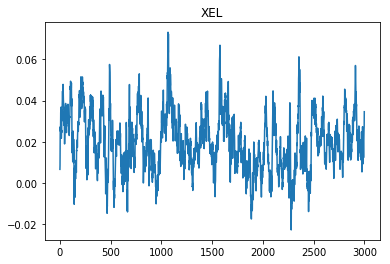

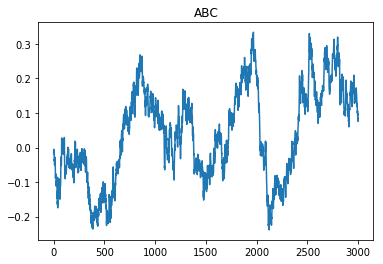

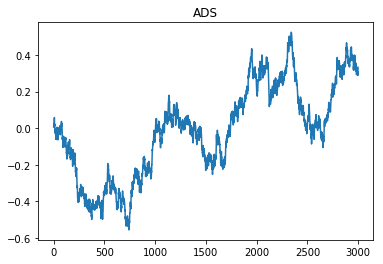

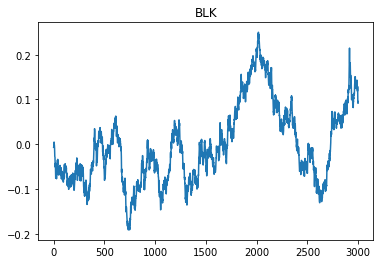

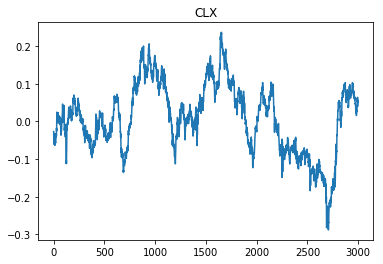

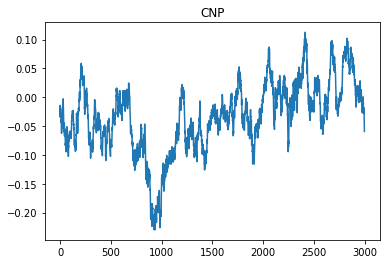

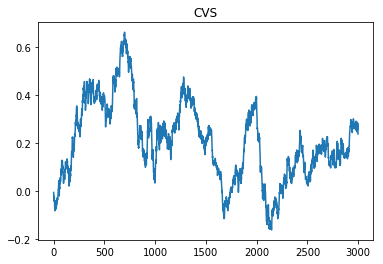

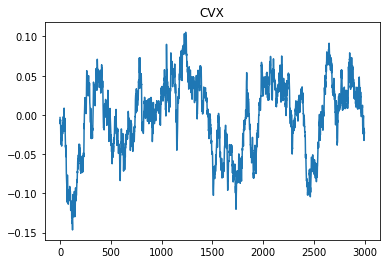

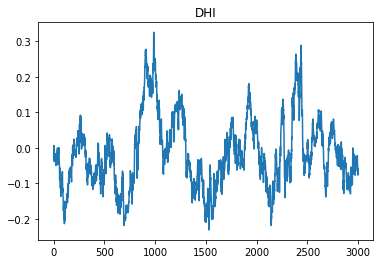

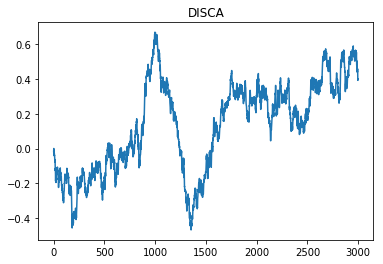

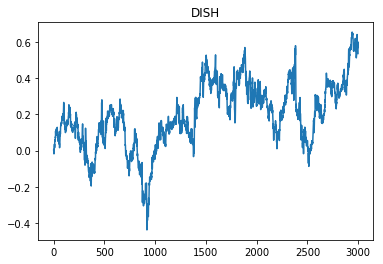

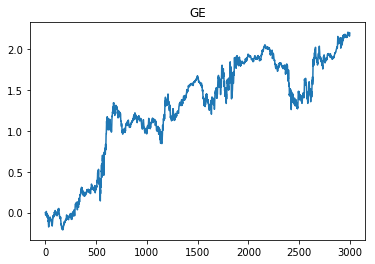

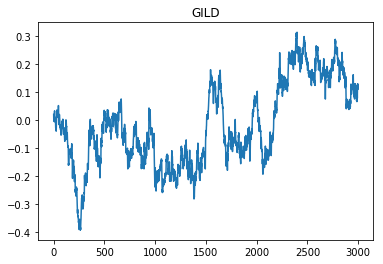

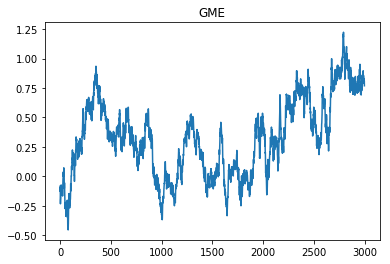

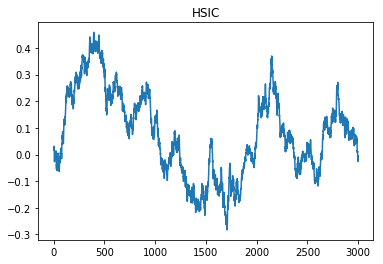

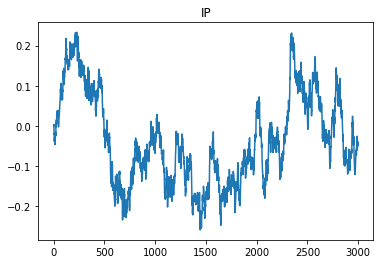

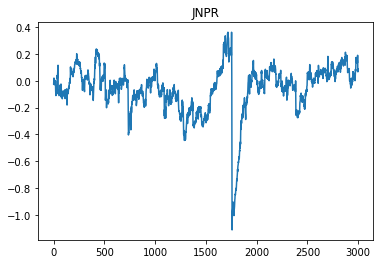

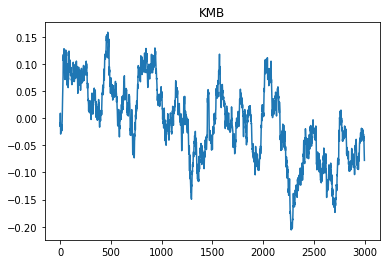

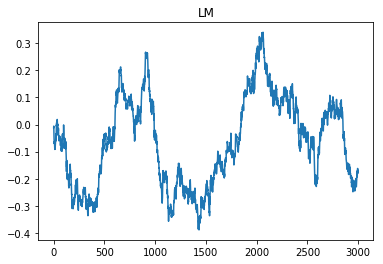

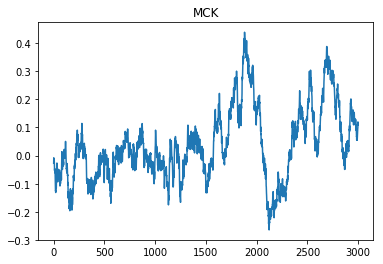

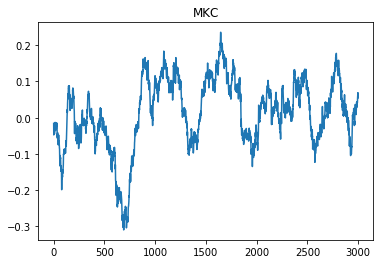

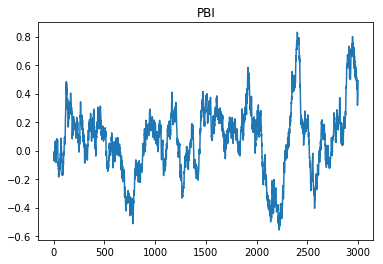

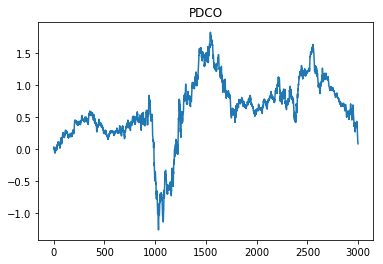

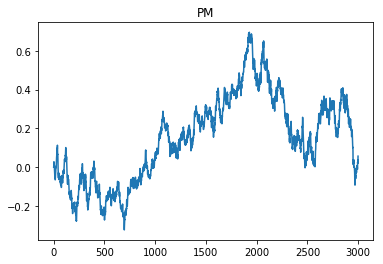

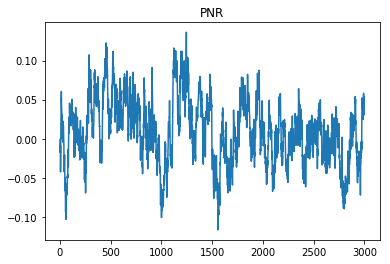

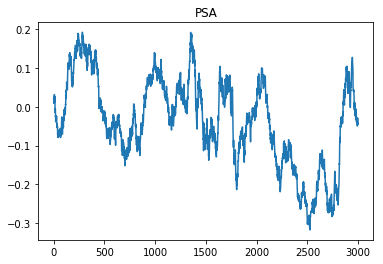

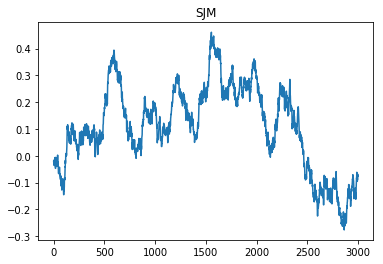

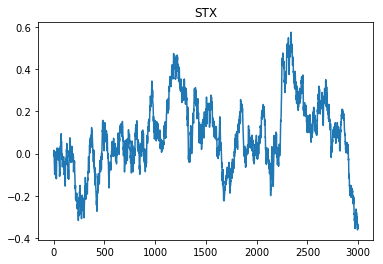

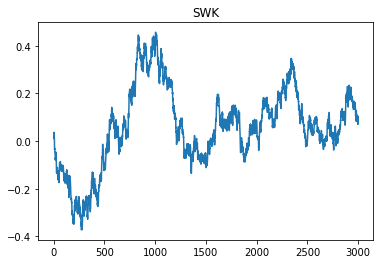

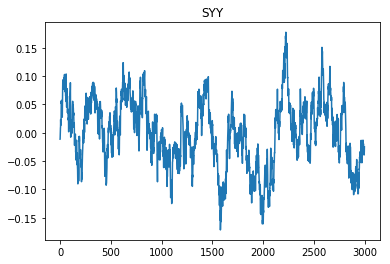

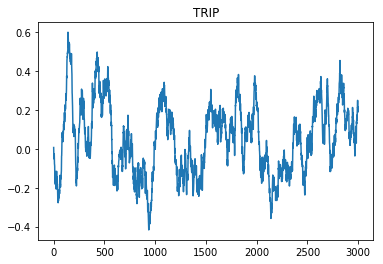

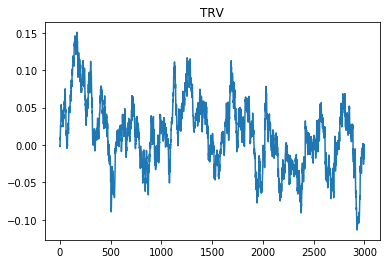

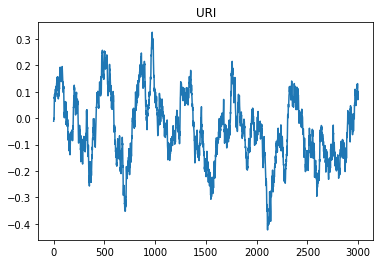

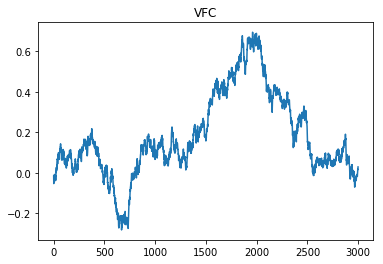

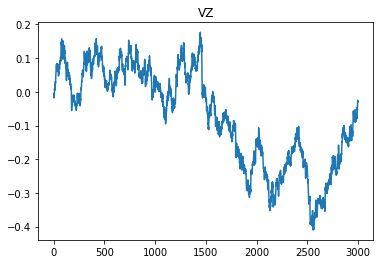

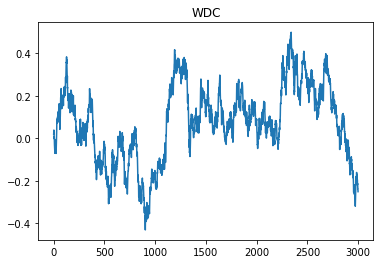

In [65]:
target_stocks = dfz_['Name'].unique()
x = np.arange(len_sim)

# plot "returns" to see if they make sense   
if True:
    for i in range(dfz.shape[1]):
        plt.figure(i)
        x = len(dfz_.loc[i*len_sim:(i+1)*len_sim-1,'Close'])
        x_len = np.arange(x)
        plt.plot(x_len,dfz_.loc[i*len_sim:(i+1)*len_sim-1,'Close'])
        plt.title(target_stocks[i])

In [22]:
# write to csv
filename = 'sim_csv_correctForm.csv'
dfz_.to_csv(filename,index=False)

In [23]:
dfz_.head()

,Date,Open,Condition Number,Condition Number,Close,Volume,Name
0,2019-10-05,1.000000,348.476081,348.476081,1.001588,0.001588,AAPL
1,2019-10-06,1.001588,298.490521,298.490521,0.993731,-0.006269,AAPL
2,2019-10-07,0.993731,260.087671,260.087671,0.994746,-0.005254,AAPL
3,2019-10-08,0.994746,227.840745,227.840745,0.994119,-0.005881,AAPL
4,2019-10-09,0.994119,210.929664,210.929664,1.004527,0.004527,AAPL


In [17]:
# use drl/src/utils/write_to_h5.ipynb to write to file type used by algorithm